<a href="https://colab.research.google.com/github/fedhere/DSPS_FBianco/blob/main/HW8/higgsbosonSearch_solution2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import json
import os
import pandas as pd
import seaborn as sns
import pylab as plt
from pprint import pprint
import numpy as np
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1 : data ingestion

- Download the Higgs boson data from Kaggle (programmatically within the notebook)
see how I did it in the Titanic Trees notebook https://github.com/fedhere/DSPS_FBianco/blob/main/CodeDemos/titanictree.ipynb

find the correct API link here https://www.kaggle.com/c/higgs-boson/data. The command is `!kaggle competitions download......` (you may need to agree to the terms of condition of the higgs boson challenge on the kaggle webpage)


In [ ]:
cd /content/drive/MyDrive/


/content/drive/MyDrive


In [ ]:
envs = json.load(open("kaggle/kaggle.json", "r"))
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [ ]:
!kaggle datasets list -s boson

ref                                                         title                                                 size  lastUpdated                 downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ---------------------------------------------  -----------  --------------------------  -------------  ---------  ---------------  
ryanholbrook/higgs-boson                                    Higgs Boson                                     1100112219  2020-10-02 23:04:26.343000           1137         11  0.375            
omidbaghchehsaraei/identification-of-two-modes-of-z-boson   Z boson DataSet                                     627191  2023-02-15 15:11:35.243000            350          9  1.0              
knight079/higgsb                                            Higgs Boson Dataset                               59325616  2017-10-17 06:27:15.307000            787          7  0.4117647        
mragpavank/higs-bonsons-and-background-p

In [ ]:
cd dsps

/content/drive/.shortcut-targets-by-id/1-5t43D_9M7Er0dU3JODw0CQdOs9lb_Gy/dsps


In [ ]:
!mkdir higgsbosons

mkdir: cannot create directory ‘higgsbosons’: File exists


In [ ]:
cd higgsbosons

/content/drive/.shortcut-targets-by-id/1-5t43D_9M7Er0dU3JODw0CQdOs9lb_Gy/dsps/higgsbosons


In [ ]:
!kaggle competitions download -c higgs-boson

higgs-boson.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip higgs-boson.zip

Archive:  higgs-boson.zip
replace HiggsBosonCompetition_AMSMetric_rev1.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!unzip training.zip

Archive:  training.zip
  inflating: training.csv            


In [ ]:
higgsdata = pd.read_csv("training.csv")

# Task 2: data exploration

In [ ]:
higgsdata.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [ ]:
higgsdata.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


do everything else you need to explore the data....

In [ ]:
higgsdata.shape

(250000, 33)

In [ ]:
higgsdata.isna().sum().sum()

np.int64(0)

In [ ]:
sns.pairplot(higgsdata[::1000])

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7db223c504a0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7db223ded9e0> (for post_execute):


KeyboardInterrupt: 

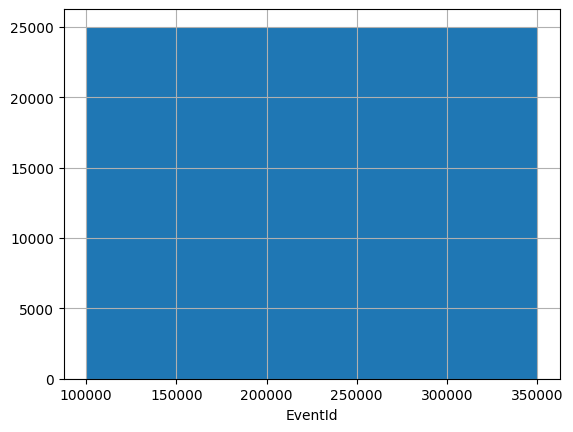

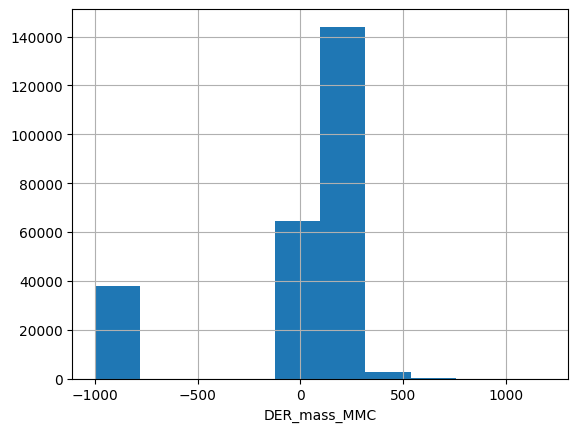

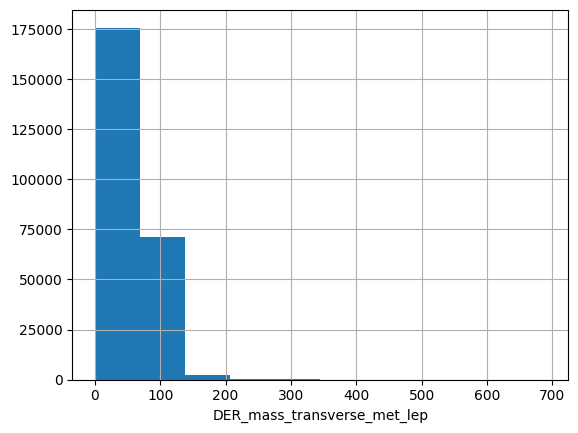

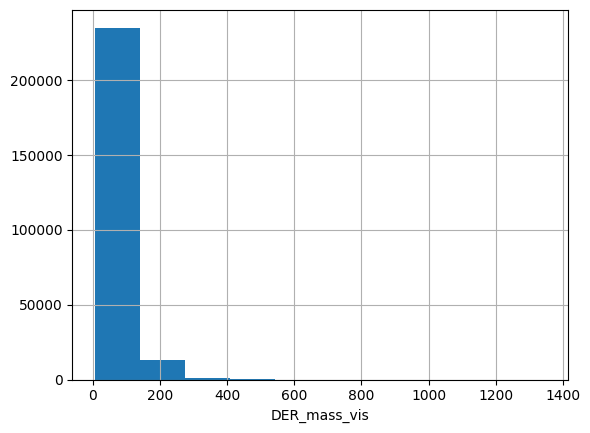

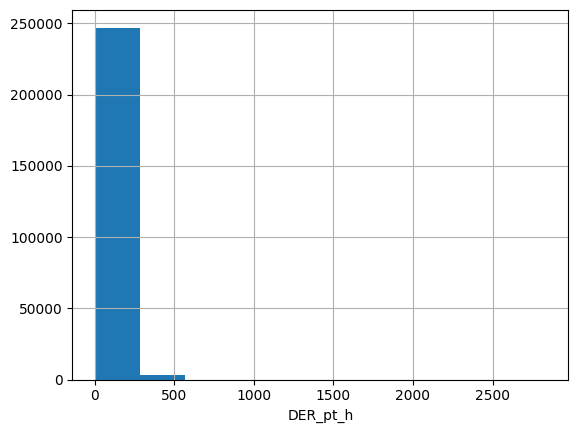

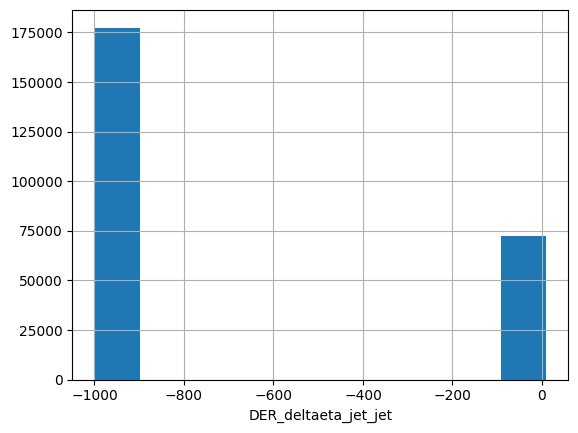

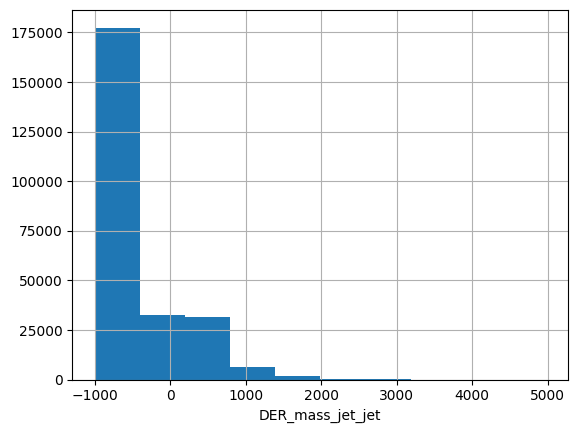

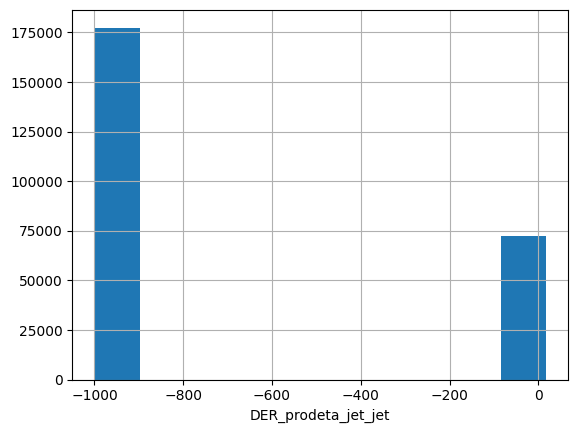

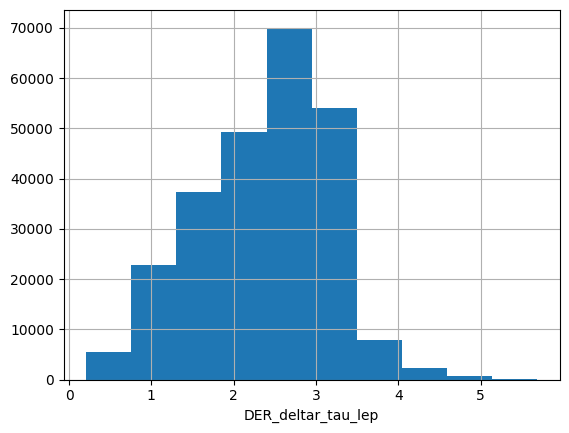

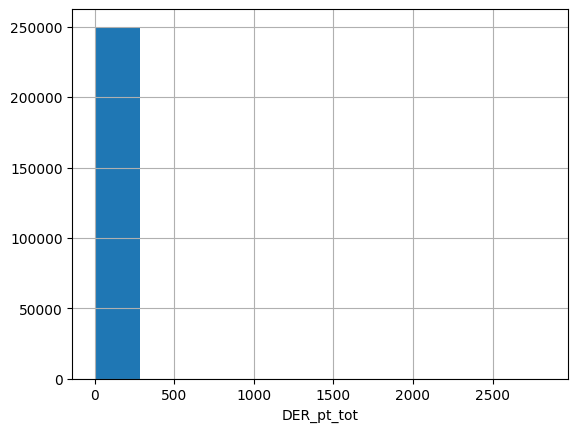

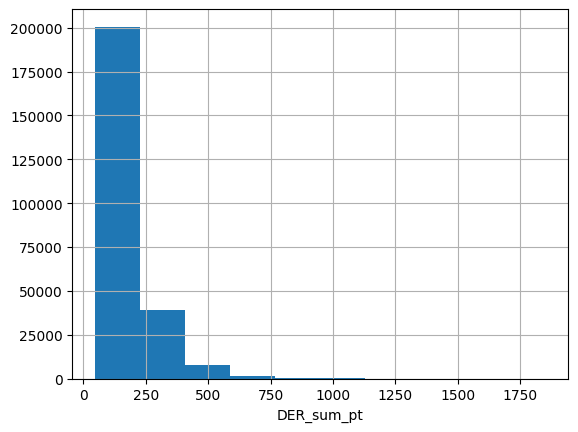

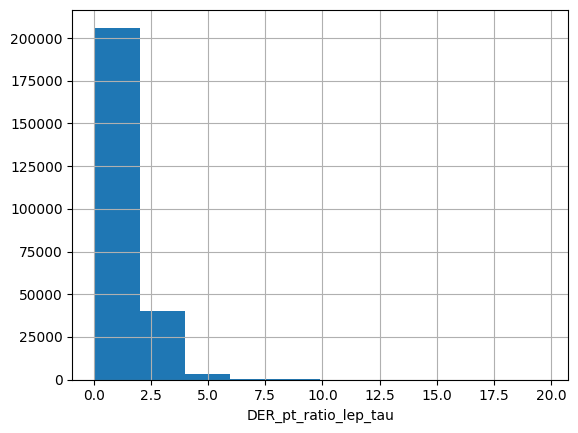

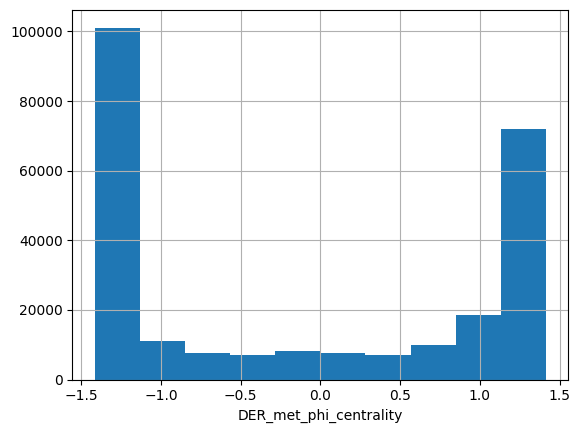

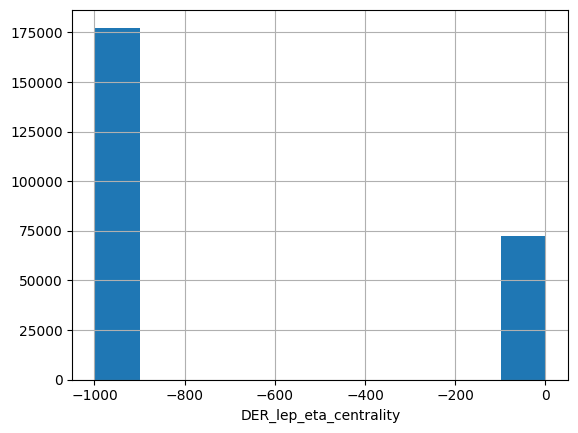

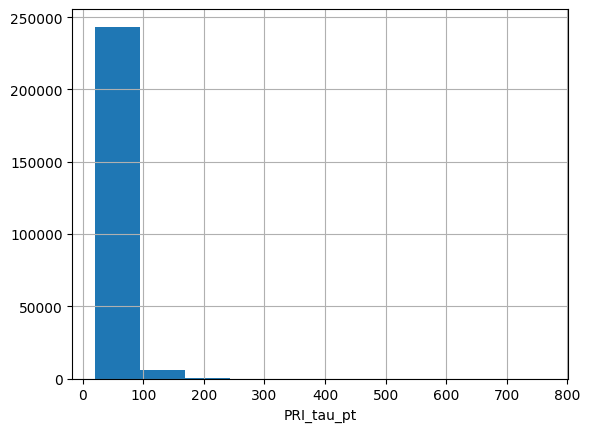

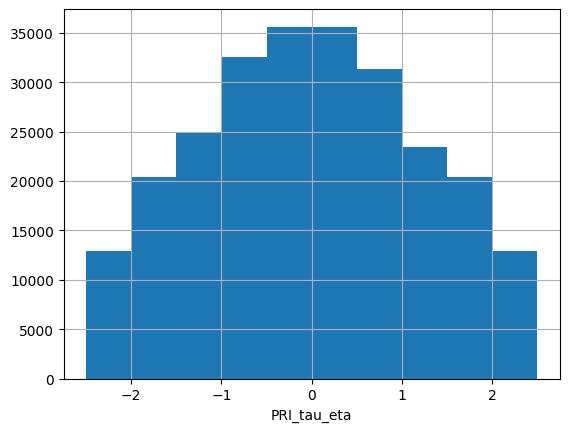

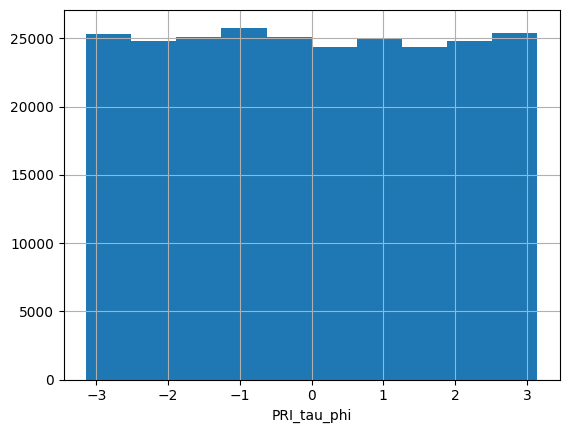

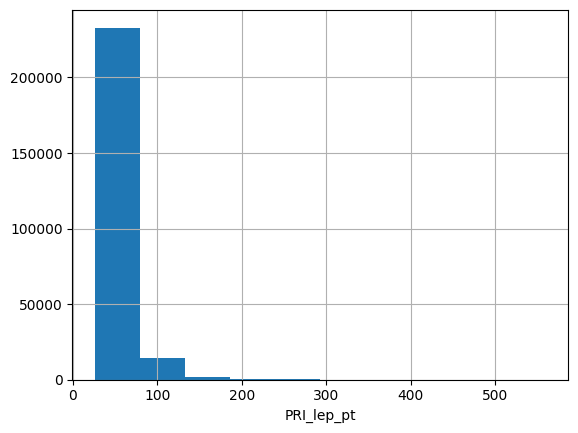

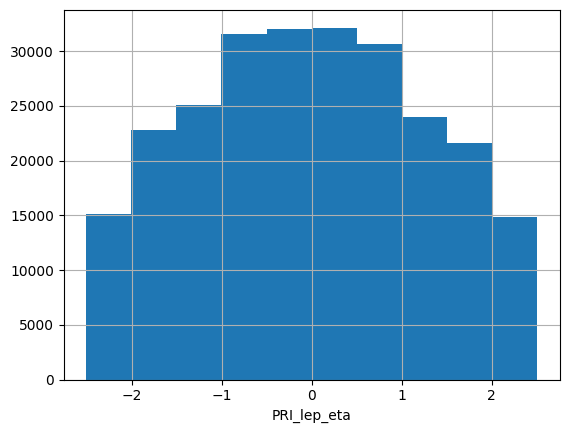

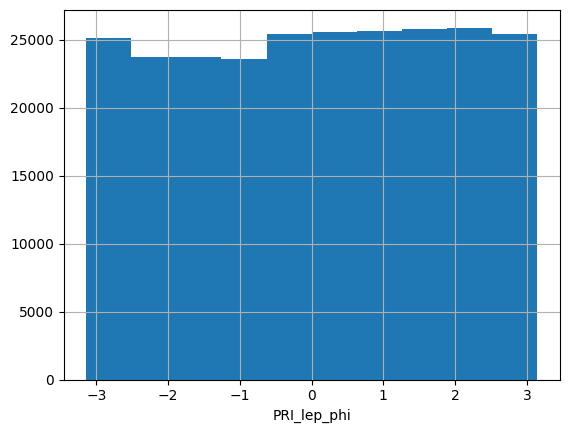

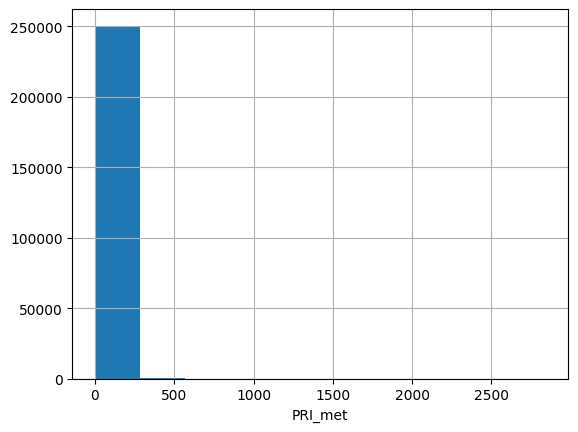

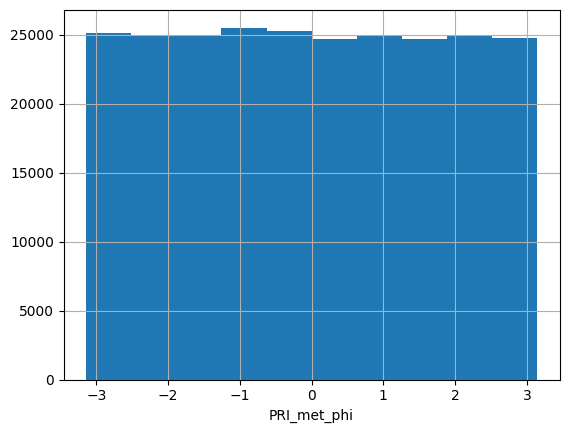

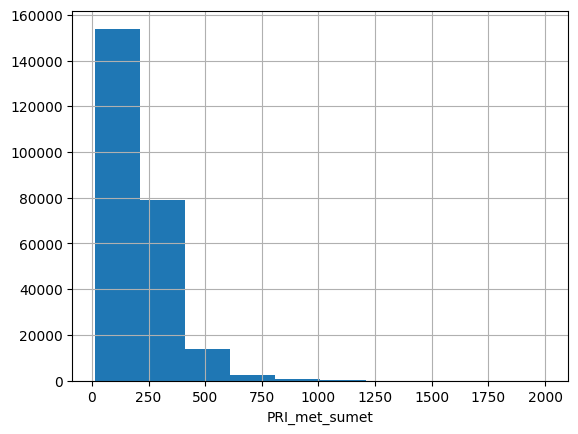

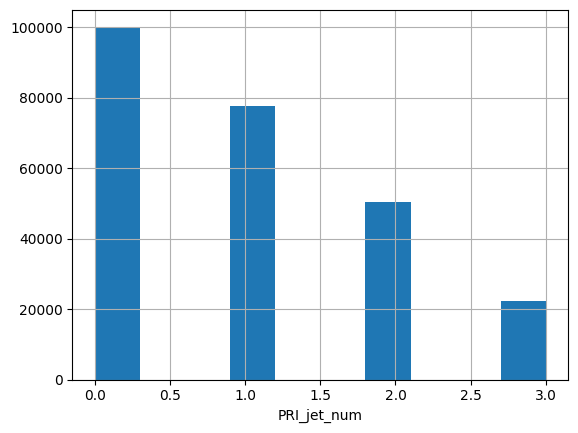

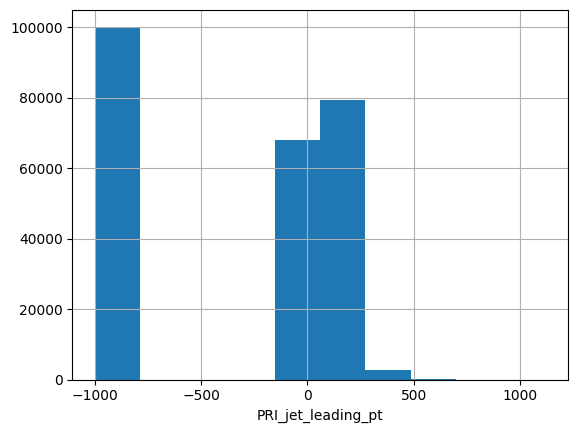

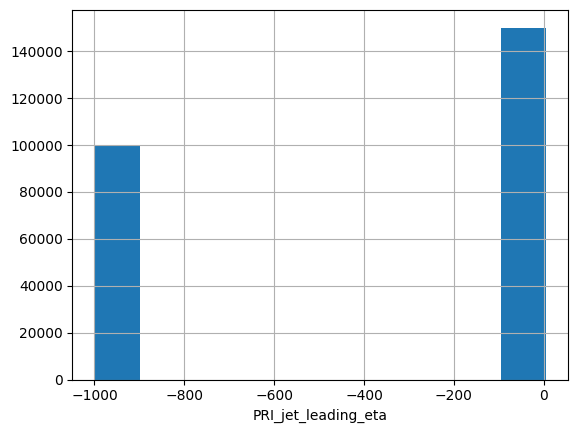

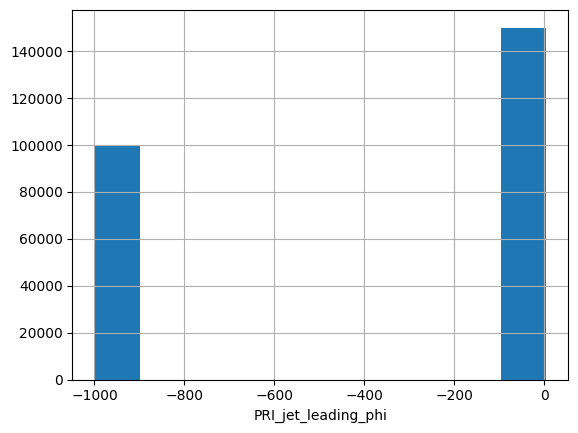

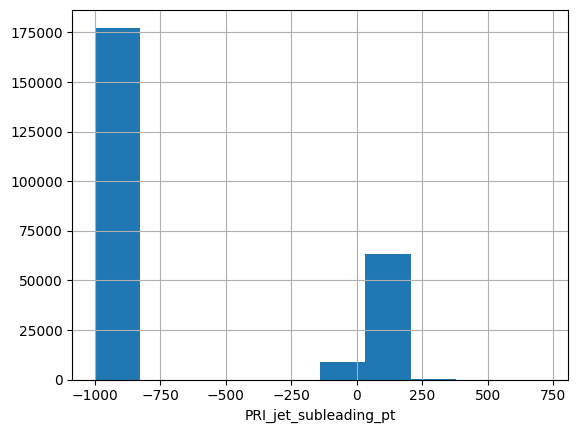

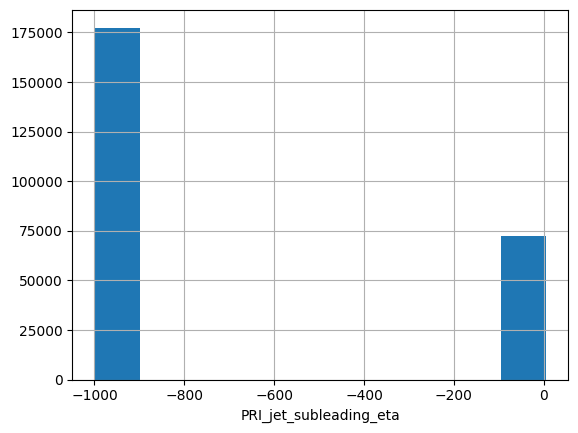

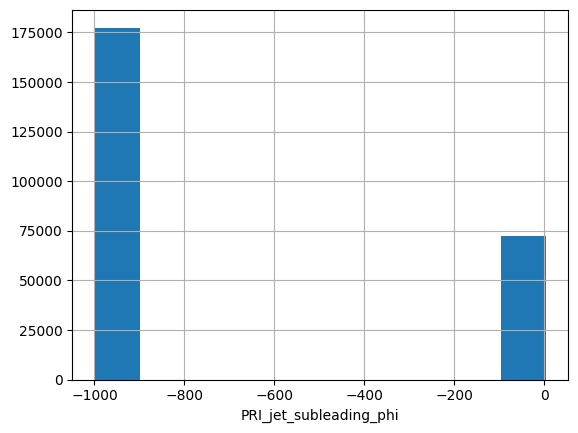

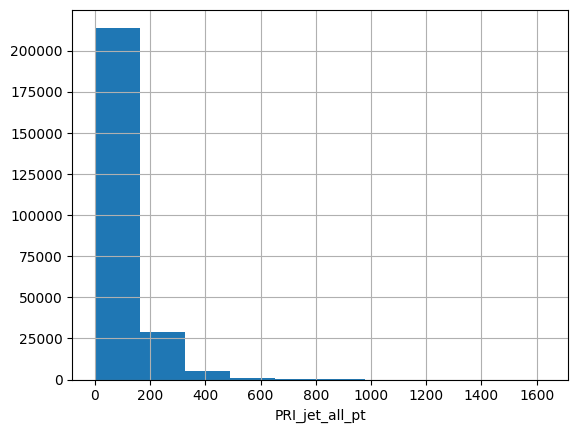

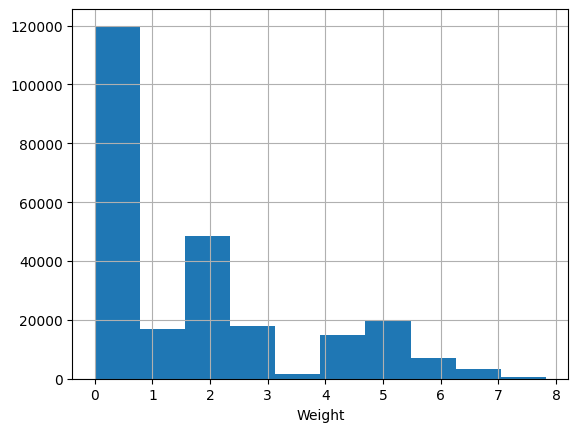

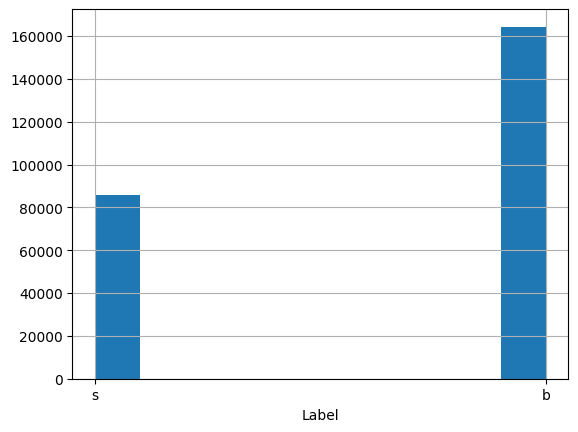

In [ ]:
for c in higgsdata.columns:
  higgsdata[c].hist()
  plt.xlabel(c)
  plt.show()

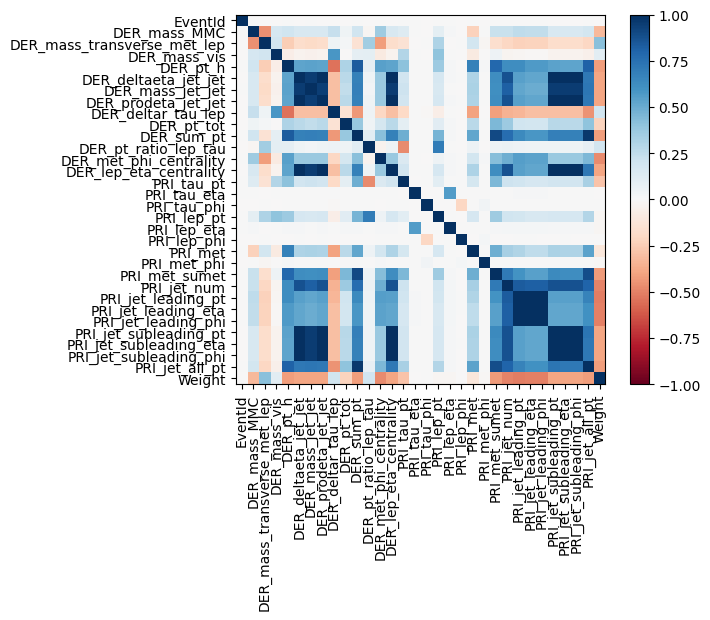

In [ ]:
correlation_matrix = higgsdata.select_dtypes(include='number').corr()
plt.imshow(correlation_matrix, cmap="RdBu", clim=(-1,1))
columns = higgsdata.select_dtypes(include='number').columns
plt.xticks(range(len(columns)), columns, rotation=90)
plt.yticks(range(len(columns)), columns);
plt.colorbar();

In [ ]:
(higgsdata==-999).sum()

,0
EventId,0
DER_mass_MMC,38114
DER_mass_transverse_met_lep,0
DER_mass_vis,0
DER_pt_h,0
DER_deltaeta_jet_jet,177457
DER_mass_jet_jet,177457
DER_prodeta_jet_jet,177457
DER_deltar_tau_lep,0
DER_pt_tot,0


In [ ]:
higgsdata.replace(-999, np.nan, inplace=True)

In [ ]:
higgsdata = higgsdata.dropna()

In [ ]:
higgsdata.shape

(68114, 33)

# Task 3: data preparation


- Read in the trainind data. Split the provided training data into a training and a test set.
The last 2 columns are what you want to predict: "weight" and "label".
Remove them from the input data and create a separate variable label and a separate variable weight, which will be your target variables for, respectively, classification and regression.



 you will use two target variables (you can read more about the data at https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf): find the corresponding columns of the DF and save them as labels and weights respectively

In [ ]:
labels = higgsdata["Label"].values
weights = higgsdata["Weight"].values

In [ ]:
labels # 's' stands for signal, 'b' for background. You want to find new particles, i.e. "signal"

array(['s', 'b', 's', ..., 's', 's', 'b'], dtype=object)

In [ ]:
weights # the weight of the particle

array([0.00265331, 0.08341403, 0.00265331, ..., 0.01863612, 0.0015027 ,
       0.06406078])

use the "training.csv" file, but create your own train/test sets

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(higgsdata.drop(["EventId", "Label", "Weight"],
                                                                   axis=1), labels, random_state=302)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((51085, 30), (51085,), (17029, 30), (17029,))

In [ ]:
train_regress_x, test_regress_x, train_regress_y, test_regress_y = train_test_split(higgsdata.drop(["EventId", "Label", "Weight"],
                                                                   axis=1), weights, random_state=302)
train_regress_x.shape, train_regress_y.shape, test_regress_x.shape, test_regress_y.shape

((51085, 30), (51085,), (17029, 30), (17029,))

#Task 4: answer the question (you, not an AI...) why did I not ask you to scale the data like we did in the cluster models?

Because the tree models use each feature separately setting binary decisions for each one in a flow-chart type model, so the relative magnitude of a feature does not matter since the features are not combined mathematically or ever compared in the model

# Task 5: tree-based classifications
: Use a Random Forest and a Gradiend Boosted Tree Classifier model to predict the label of the particles. get the score of each model on both the training and test set, compare them training and test results and comment on the result for each model (adjust the hyperparameters if you need to)


In [ ]:

# Look at parameters used by our current forest
rf = RandomForestClassifier(random_state = 0)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [ ]:
rf = RandomForestClassifier(max_depth=3, random_state=302)

In [ ]:
gbt = GradientBoostingClassifier(max_depth=3, random_state=302)

In [ ]:
rf.fit(train_x, train_y)
gbt.fit(train_x, train_y)

GradientBoostingClassifier(random_state=302)

# Task 6: model evaluation

calculate the  scores for the training and test sets and evaluate  overtraining etc

In [ ]:
print(f"the RF scores on the training test is {rf.score(train_x, train_y):.2f}, on the test is {rf.score(test_x, test_y):.2f}")
print("this indicated NO overfitting")
print(f"the GBT scores on the training test is {gbt.score(train_x, train_y):.2f}, on the test is {gbt.score(test_x, test_y):.2f}")
print("this indicated NO overfitting")


the RF scores on the training test is 0.80, on the test is 0.80
this indicated NO overfitting
the GBT scores on the training test is 0.85, on the test is 0.84
this indicated NO overfitting


**Comment** is your model performing well? is it .... overfitting?

- Produce a confusion matrix for each model and compare them






In [ ]:

# I creaded this function (mostly copied from sklearn examples).
# You can use it to create the confusion matrix


def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='', labels=["P", "N"],
                          cmap=plt.cm.bone):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
          title = title + ' Normalized confusion matrix'
    else:
          title = title + ' Confusion matrix, without normalization'
    # Compute confusion matrix
    if normalize:
      cm = confusion_matrix(y_true, y_pred, normalize='all')
    else:
      cm = confusion_matrix(y_true, y_pred)
    # plot it
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust()
    im = ax.imshow(np.rot90(cm), cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    plt.xticks([0, 1], labels=labels[::-1])

    plt.text(0,1, cm[0,0], ha='center', c="k" if cm[0,0] > 0.3 * cm.sum() else "w")
    plt.text(0,0, cm[0,1], ha='center', c="k" if cm[0,1] > 0.3 * cm.sum() else "w")
    plt.text(1,1, cm[1,0], ha='center', c="k" if cm[1,0] > 0.3 * cm.sum() else "w")
    plt.text(1,0, cm[1,1], ha='center', c="k" if cm[1,1] > 0.3 * cm.sum() else "w")
    plt.ylim(-0.5,1.5)
    plt.yticks([0,1], labels=labels)
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.title(title)
    cax = ax_divider.append_axes("right", size="10%", pad="2%")
    cb = plt.colorbar(im, cax=cax)


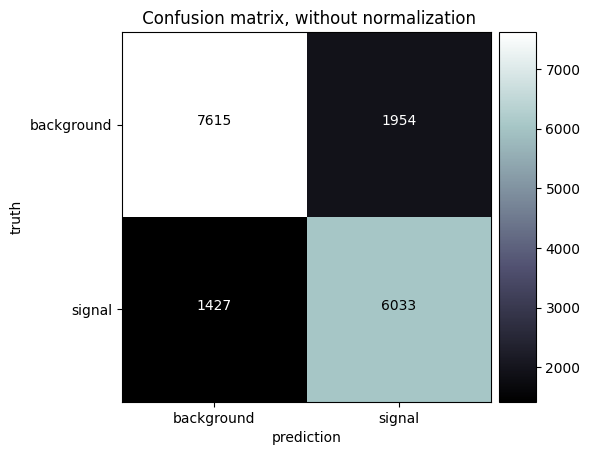

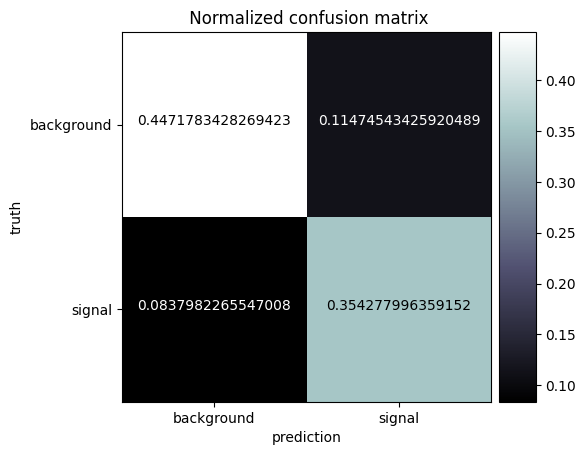

In [ ]:
plot_confusion_matrix(test_y, rf.predict(test_x), labels=["signal", "background"])
plot_confusion_matrix(test_y, rf.predict(test_x), labels=["signal", "background"], normalize=True)

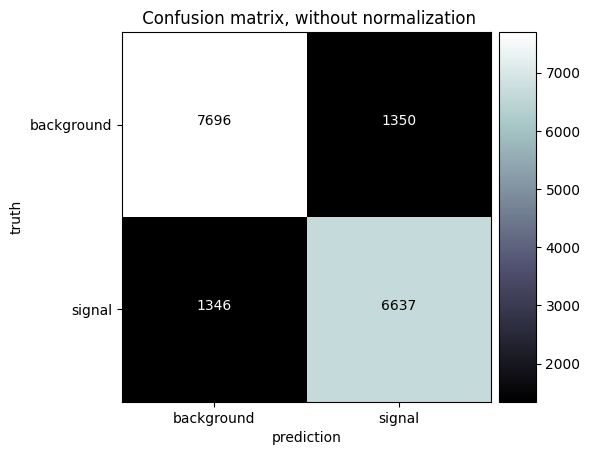

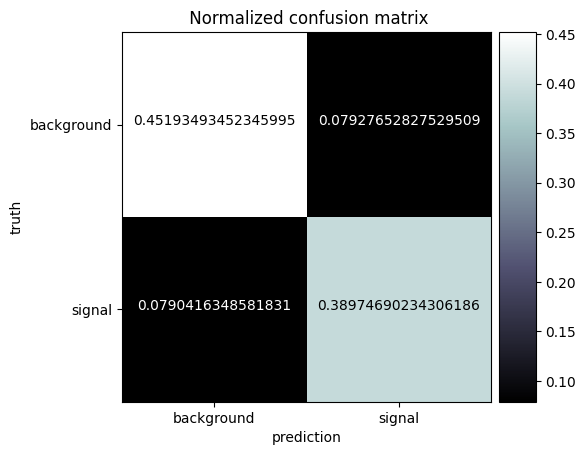

In [ ]:
plot_confusion_matrix(test_y, gbt.predict(test_x), labels=["signal", "background"])
plot_confusion_matrix(test_y, gbt.predict(test_x), labels=["signal", "background"], normalize=True)

Plot a simple ROC curve for the RF and GBT models  Describe it.

In [ ]:
roc_curve?
rf.predict_proba(test_x)[:,1]

Object `roc_curve` not found.


array([0.45862232, 0.33642163, 0.25756664, ..., 0.23420109, 0.22739388,
       0.51081692])

In [ ]:
test_y.reshape(-1, 1).flatten()=="s"

array([ True,  True, False, ..., False, False,  True])

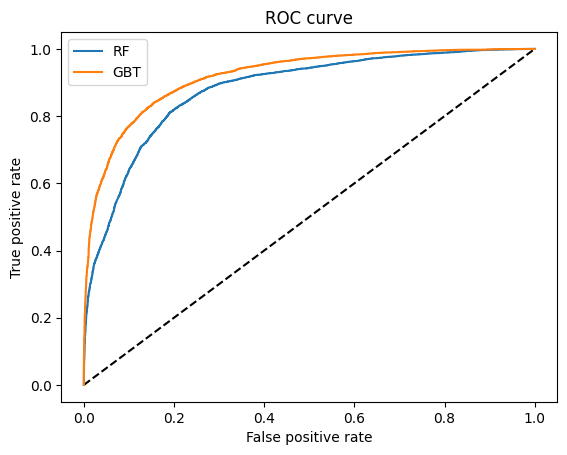

In [ ]:
# The random forest model by itself
from sklearn.metrics import roc_curve
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


#Task 7 required for 661, EC for 461, tree-based regression


- Use a Random Forest and a Gradiend Boosted Tree Regressor model to predict the weight of the particles. Compare the model performance on training and test setsm


In [ ]:
rfR = RandomForestRegressor(max_depth=3, random_state=302)
rfR.fit(train_regress_x, train_regress_y)
gbtR = GradientBoostingRegressor(max_depth=3, random_state=302)
gbtR.fit(train_regress_x, train_regress_y)

KeyboardInterrupt: 

 Calculate the L2 and L1 loss functions for the fitted regression models (see slides for the definition) and discuss the results

In [ ]:
def L1(truth, prediction):
  return np.sum(np.abs(truth - prediction)) / len(truth)

def L2(truth, prediction):
  return np.sum((truth - prediction)**2) / len(truth)

In [ ]:

print(f"L1 RF {L1(test_regress_y,  rfR.predict(test_regress_x)):.2f}, L2 RF {L2(test_regress_y, rfR.predict(test_regress_x)):.2f}")

In [ ]:
print(f"L1 GBT {L1(test_regress_y,  gbtR.predict(test_regress_x)):.2f}, L2 GBT {L2(test_regress_y, gbtR.predict(test_regress_x)):.2f}")

**Discuss!**

In [ ]:
np.median(test_regress_y)

In [ ]:
rfR.score(test_regress_x,  test_regress_y), gbtR.score(test_regress_x,  test_regress_y)

#Task 8: Choose between feature importance and grid optimization (due for both 461 and 661)







# Task 8a: feature importance
Use the "Titanic notebook" as a guide for the feature importance analysis  https://github.com/fedhere/DSPS_FBianco/blob/main/Labs/DSPS_2025_titanictree.ipynb

- For the Random Forest classifier, find the 4 most important features based on the simple unoptimized model you created earlier on. Use the documentation to find out what they are. We have not talked abotu the physics of this problem at all but the Kaggle challenge description should provide enogh information for you to comment on this result is somewhat superficially.

You can use ```rf.feature_importance_``` on the trained model to extract the relative importance of each feature (a number from 0 to 1) and then choose the features that have the 4 highest numbers (the numpy function ```argsort()``` is helpful here!)



In [ ]:
fistd = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
print("Random Forest feature importance")
for f, fi, s in zip (higgsdata.drop(["EventId", "Label", "Weight"], axis=1).columns, rf.feature_importances_, fistd):
  print (f, fi.round(2), "+/-", s.round(2))


Random Forest feature importance
DER_mass_MMC 0.3 +/- 0.28
DER_mass_transverse_met_lep 0.05 +/- 0.08
DER_mass_vis 0.09 +/- 0.13
DER_pt_h 0.01 +/- 0.02
DER_deltaeta_jet_jet 0.13 +/- 0.19
DER_mass_jet_jet 0.07 +/- 0.15
DER_prodeta_jet_jet 0.13 +/- 0.19
DER_deltar_tau_lep 0.02 +/- 0.04
DER_pt_tot 0.03 +/- 0.07
DER_sum_pt 0.0 +/- 0.01
DER_pt_ratio_lep_tau 0.01 +/- 0.03
DER_met_phi_centrality 0.04 +/- 0.07
DER_lep_eta_centrality 0.07 +/- 0.14
PRI_tau_pt 0.01 +/- 0.03
PRI_tau_eta 0.0 +/- 0.0
PRI_tau_phi 0.0 +/- 0.0
PRI_lep_pt 0.0 +/- 0.0
PRI_lep_eta 0.0 +/- 0.01
PRI_lep_phi 0.0 +/- 0.0
PRI_met 0.01 +/- 0.02
PRI_met_phi 0.0 +/- 0.0
PRI_met_sumet 0.0 +/- 0.0
PRI_jet_num 0.03 +/- 0.06
PRI_jet_leading_pt 0.0 +/- 0.0
PRI_jet_leading_eta 0.0 +/- 0.02
PRI_jet_leading_phi 0.0 +/- 0.0
PRI_jet_subleading_pt 0.0 +/- 0.01
PRI_jet_subleading_eta 0.01 +/- 0.02
PRI_jet_subleading_phi 0.0 +/- 0.0
PRI_jet_all_pt 0.0 +/- 0.01


In [ ]:
best_features_index = np.argsort(rf.feature_importances_)


In [ ]:
higgsdata.drop(["EventId", "Label", "Weight"], axis=1).iloc[:, best_features_index[::-1]] #this sorts the data by feature

,DER_mass_MMC,DER_deltaeta_jet_jet,DER_prodeta_jet_jet,DER_mass_vis,DER_lep_eta_centrality,DER_mass_jet_jet,DER_mass_transverse_met_lep,DER_met_phi_centrality,DER_pt_tot,PRI_jet_num,...,PRI_jet_all_pt,PRI_met_sumet,PRI_tau_eta,PRI_lep_pt,PRI_met_phi,PRI_jet_leading_phi,PRI_lep_phi,PRI_jet_leading_pt,PRI_jet_subleading_phi,PRI_tau_phi
0,138.470,0.910,2.666,97.827,0.200,124.711,51.655,1.396,41.928,2,...,113.497,258.733,1.017,51.626,-0.277,0.444,-2.414,67.435,-2.475,0.381
5,89.744,2.636,-0.540,59.149,0.975,284.584,13.550,0.479,61.619,3,...,193.660,282.849,0.371,31.565,2.237,-0.653,1.857,90.547,3.106,1.329
6,148.754,0.733,0.113,107.782,0.791,158.359,28.862,1.393,2.545,2,...,179.877,294.074,1.113,97.240,-1.443,1.450,-0.966,123.010,-2.767,2.409
11,114.744,2.563,-1.401,75.712,0.769,252.599,10.286,1.364,36.745,3,...,165.640,290.547,-0.669,38.188,2.148,0.303,2.502,76.773,-2.079,-0.342
23,141.481,1.955,-0.923,111.581,0.207,364.344,0.736,1.042,6.663,2,...,278.009,454.785,0.190,64.285,-0.973,1.416,-0.952,195.533,-2.785,-1.506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249976,137.371,3.189,-2.384,92.603,0.503,322.430,4.640,1.090,2.755,2,...,136.200,228.186,0.599,57.056,1.408,-1.518,1.503,85.132,-2.831,-0.013
249980,119.934,0.660,1.836,88.751,0.000,111.491,20.078,0.304,18.532,2,...,112.938,237.326,1.159,50.416,1.116,1.118,-1.558,69.219,-2.756,0.823
249985,126.151,1.000,-0.240,95.258,0.027,163.066,29.023,0.490,24.642,2,...,193.099,402.114,1.980,91.908,-2.575,0.034,-3.050,158.904,-2.525,2.239
249993,130.075,0.936,-0.207,66.781,0.000,322.296,3.918,-0.634,49.937,3,...,546.066,694.010,2.403,37.052,-1.768,1.093,-1.689,155.864,-2.215,1.348


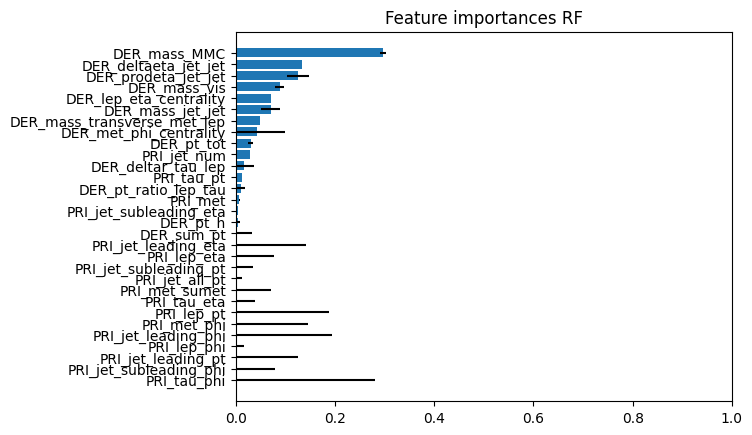

In [ ]:
plt.figure()
plt.title("Feature importances RF")
plt.barh(np.arange(rf.feature_importances_.shape[0]),
        rf.feature_importances_[best_features_index], xerr=fistd,
       align="center")
plt.yticks(range(rf.feature_importances_.shape[0]),
          labels=higgsdata.drop(["EventId", "Label", "Weight"], axis=1).columns[best_features_index])
plt.xlim(0, 1)
plt.show()

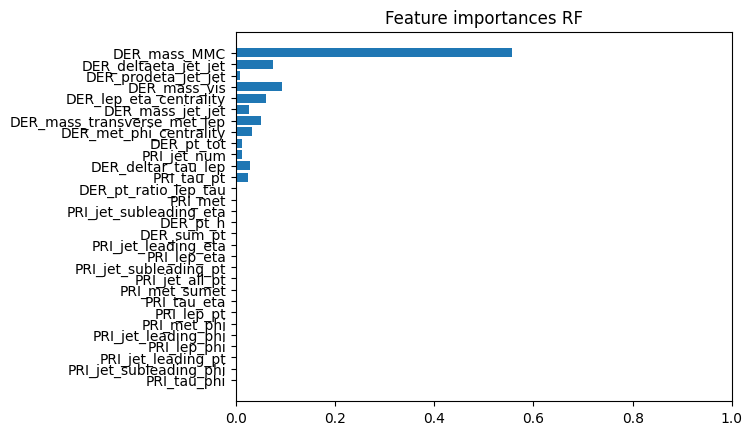

In [ ]:
plt.figure()
plt.title("Feature importances RF")
plt.barh(np.arange(gbt.feature_importances_.shape[0]),
        gbt.feature_importances_[best_features_index],
       align="center")
plt.yticks(range(gbt.feature_importances_.shape[0]),
          labels=higgsdata.drop(["EventId", "Label", "Weight"], axis=1).columns[best_features_index])
plt.xlim(0, 1)
plt.show()

# Task 8b: hyperparameters grid search
- Explore the parameter space with the sklearn module ```sklearn.model_selection.RandomizedSearchCV``` *fitting only those 4 features*

Follow this example to set up the parameter search. Set the estimators to 10 and 100, (the number of trees) and the max depth to 3, and 10, and None (let it be unconstrained). Set bootstrap to both True and False. Set the number of features to consider at every split to both "autp" and "sqrt". Use ```pprint``` like I did earlier in this notebook to print the parameters set

**this takes some computational time! so do not start this at the last minute!!**

In [ ]:
# choose your preferred values for the parameters you will test
random_grid = {
 'max_depth': [None, 10, 3],
 'max_features': ['sqrt', 'log2'],
 'n_estimators': [10,100, 500]}


In [ ]:
random_grid = {'n_estimators': [10, 100],
               'max_depth': [3, 10, None],
               'bootstrap': [True, False],
               'max_features': ['autp', 'sqrt']}

In [ ]:
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [3, 10, None],
 'max_features': ['autp', 'sqrt'],
 'n_estimators': [10, 100]}


 mine and your best features do not necessarily have to be the same because our models may be different (different parameters, different random seed etc)

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation,
# search across 18 different combinations
random_search = RandomizedSearchCV(estimator = rf, param_distributions=random_grid,
                                   n_iter=1, cv=3)


Note that this may take a long time! It took 1 hour for me to run this. Dont start at the last minute!!

In [ ]:
random_search.fit(train_x[::5], train_y[::5])


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=3,
                                                    max_features='log2',
                                                    n_estimators=10),
                   n_iter=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 10, None],
                                        'max_features': ['autp', 'sqrt'],
                                        'n_estimators': [10, 100]})

In [ ]:
random_search.best_estimator_

RandomForestClassifier(n_estimators=10)

In [ ]:
for k in random_search.best_params_:
  print(k,random_search.best_params_[k])

n_estimators 10
max_features sqrt
max_depth None
bootstrap True


In [ ]:
rf = RandomForestClassifier(max_features="autp")
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'autp',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
rf = RandomForestClassifier(**random_search.best_params_)
pprint(rf.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
rf.fit(train_x, train_y)

InvalidParameterError: The 'max_features' parameter of RandomForestClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'autp' instead.

In [ ]:
print("Tuned RF  Parameters: {}".format(random_search.best_params_))
print("Best score is {}".format(rf.score(test_x, test_y)))


Tuned RF  Parameters: {'n_estimators': 10, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
Best score is 0.8272358917141347


In [ ]:
df = pd.DataFrame(random_search.cv_results_) # this shows the result for the given parameters


In [ ]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.500636,0.04038,0.010413,0.000352,10,sqrt,None,True,"{'n_estimators': 10, 'max_features': 'sqrt', '...",0.804169,0.806812,0.83025,0.813743,0.011721,1


Plot a simple  ROC curve for the RF model with the best parameters found in the previous step. Describe it.

In [ ]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()